In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [18]:
X = fashion.iloc[:10000, 1:]
y = fashion.iloc[:10000, 0]

In [19]:
from sklearn.model_selection import train_test_split 

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


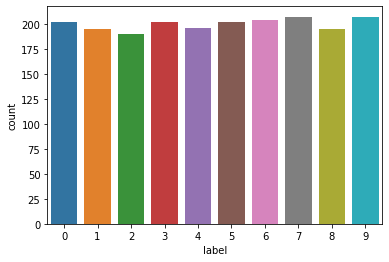

In [20]:
sns.countplot(test_y)
plt.show()

In [21]:
#train_y에 균등하게 라벨값이 저장되었음을 확인했다.

- 어떻게 생긴 데이터셋인지 확인해보기

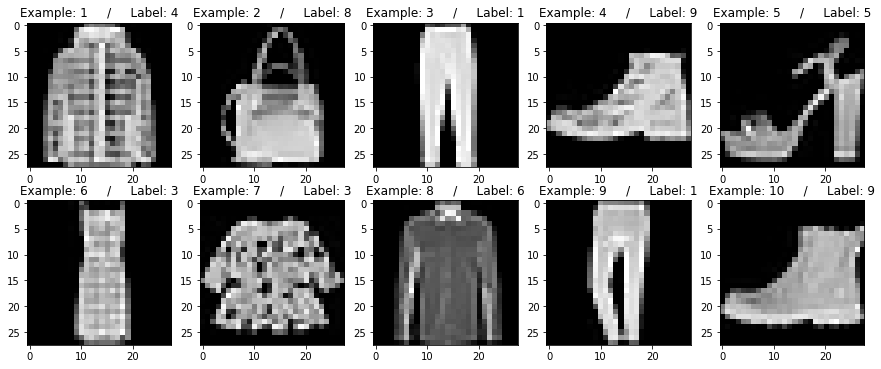

In [22]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = train_y.iloc[i]
  image = train_X.iloc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [24]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
train_X_PCA=pca.fit_transform(train_X)
train_X_PCA.shape

(8000, 784)

In [30]:
pca.explained_variance_ratio_[:10]

array([0.29007947, 0.17529191, 0.06038132, 0.05079348, 0.03811337,
       0.03514448, 0.02286128, 0.01962059, 0.01346988, 0.01306312])

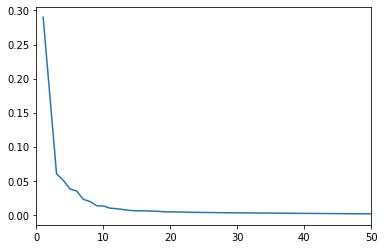

In [31]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

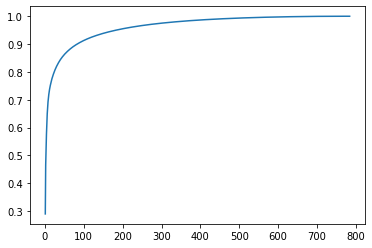

In [34]:
## culumative 

cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

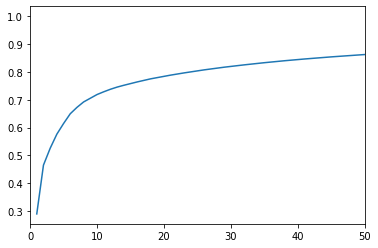

In [35]:
plt.plot(range(1,785),cumulative)
plt.xlim(0,50)
plt.show()

In [36]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.88%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.42%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.25%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.30%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [38]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #전체 데이터의 80%

23

In [44]:
pca=PCA(n_components=23)
train_X_PCA=pca.fit_transform(train_X) 
test_X_PCA=pca.transform(test_X)

In [45]:
print('Original space:',train_X.shape)
print('After PCA:',train_X_PCA.shape)

Original space: (8000, 784)
After PCA: (8000, 23)


In [46]:
## 784에서 23으로 차원 축소가 되었다.

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [48]:
##LogisticRegression

start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(train_X,train_y)  #train set만 고려
print('train accuracy:',accuracy_score(train_y, logistic_original.predict(train_X)))
print('test accuracy:',accuracy_score(test_y, logistic_original.predict(test_X)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.7635
85.3989sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
#차원축소 이후(23차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(train_X_PCA,train_y)
print('train accuracy:',accuracy_score(train_y, logistic_pca.predict(train_X_PCA)))
print('test accuracy:',accuracy_score(test_y, logistic_pca.predict(test_X_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.817375
test accuracy: 0.814
12.5369sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

###PCA

In [50]:
start=time.time()
pca=PCA(n_components=2)
train_X_PCA=pca.fit_transform(train_X) 
print(f'{time.time()-start:.4f}sec')

0.8219sec


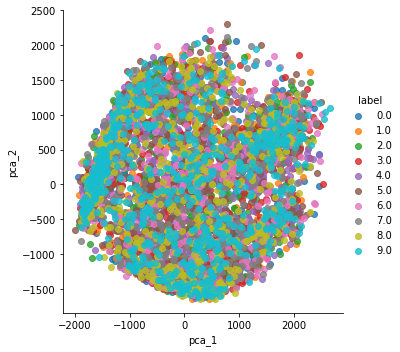

In [51]:
train_X_pca=pd.DataFrame(train_X_PCA).loc[:,0:1]
train_X_pca=pd.concat((train_X_pca, train_y), axis=1) 
train_X_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=train_X_pca,hue='label',fit_reg=False)
plt.show()

###MDS

In [52]:
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(train_X)
print(f'{time.time()-start:.4f}sec')

2272.4318sec


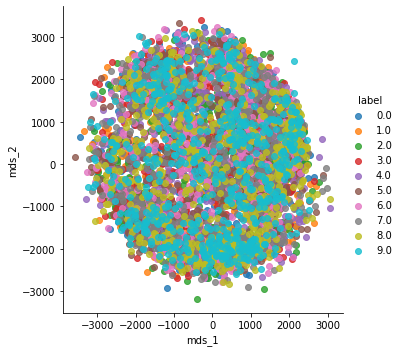

In [53]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds=pd.concat((X_train_mds, train_y), axis=1) 
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

###LDA

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(train_X, train_y) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

4.3649sec


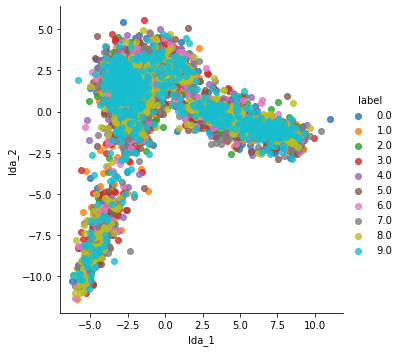

In [55]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, train_y), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

###KPCA

In [57]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(train_X)
print(f'{time.time()-start:.4f}sec')

33.6239sec


In [58]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(train_X)
print(f'{time.time()-start:.4f}sec')

32.3011sec


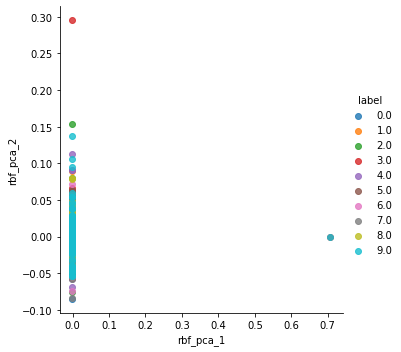

In [59]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, train_y), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

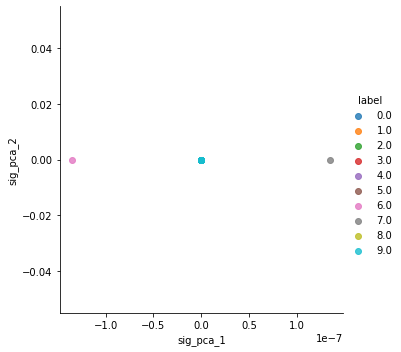

In [60]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, train_y), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

###ISOMAP

In [61]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=10,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(train_X)
print(f'{time.time()-start:.4f}sec')

67.0795sec


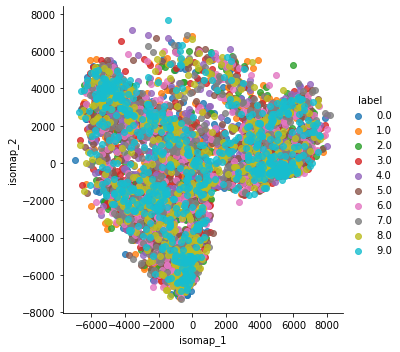

In [62]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, train_y), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

어떠한 차원 축소 방법이 잘 시각화했다고 특정 지어 이야기하긴 어려운 것 같다. 차원 축소를 해보면서 연산 시간은 줄었지만 결과만 보자면 시각화 결과가 좋지는 않다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

라벨 또한 전반적으로 분류가 잘 되지 않았다.

수고하셨습니다~